<a href="https://colab.research.google.com/github/layely/DeepLearning-Course-UdeM/blob/master/TP1_DenseNet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation


## Connect to Google Drive


In [0]:
# Code to read csv file into Colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Download dataset (zip file)

In [0]:
import os

# Gdrive link of the dataset 
link = 'https://drive.google.com/open?id=1UmA1WKqZfOkN0EP5lno8h9aAbFDIZ-hQ'
  
_, id = link.split('=')

# Download if zip file does not exist
if os.path.isfile('chest_xray.zip'):
  print("archive already downloaded")
else:
  print("Downloading dataset (chest_xray.zip)...")
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile('chest_xray.zip')
  print("Donwload finished")

Donwload finished


## Extract dataset archive

In [0]:
# Extract dataset archive
import zipfile

EXTRACT_PATH = "chest_x_ray_densenet"


try:
  !rm -r {EXTRACT_PATH}
except:
  pass

archive = zipfile.ZipFile('chest_xray.zip', 'r')
archive.extractall(path=EXTRACT_PATH)


if os.path.isdir(EXTRACT_PATH):
  print("archive successfully extracted")
else:
  print("Can't extract archive")
  


archive successfully extracted


In [0]:
!ls {EXTRACT_PATH}/chest_xray

test  train  val


## Re-balance train/val distribution
**To run only once!!!**

At this point, the validation set consist of only 16 images. In order to improve the robustness of the model, we copy from the training 2x216 images to increase the proportion of images in the validation set.

In [0]:

# By default we have only 16 images in the validation folder
# To rebalance the distribution train/val, we copy a subset from
# train folder to val folder

!mv `ls -d {EXTRACT_PATH}/chest_xray/train/NORMAL/* | head -216` {EXTRACT_PATH}/chest_xray/val/NORMAL/ #112
!mv `ls -d {EXTRACT_PATH}/chest_xray/train/PNEUMONIA/* | head -216` {EXTRACT_PATH}/chest_xray/val/PNEUMONIA/

## Load dataset with ImageGenerators

We load the dataset via ImageDataGenerator provided in Keras. We also applied some augmentation on the training and validation set which slightly improved our models performance during testing. The transformations includes random horizontal flipping (for both training et validation) and small rotation (<=10°) and zoom (<=0.1) only on the training set.


In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, \
  img_to_array, load_img
from keras.applications.densenet import preprocess_input


def getImageGenerators(target_size=(224, 224), batch_size=16):
  train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=10, zoom_range=0.1, horizontal_flip=True)
  val_datagen = ImageDataGenerator(horizontal_flip=True, preprocessing_function=preprocess_input)
  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      directory=r"./{}/chest_xray/train/".format(EXTRACT_PATH),
      target_size=target_size,
      color_mode="rgb",
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=True,
      seed=42
  )

  val_generator = val_datagen.flow_from_directory(
      directory=r"./{}/chest_xray/val/".format(EXTRACT_PATH),
      target_size=target_size,
      color_mode="rgb",
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=True,
      seed=42
  )

  test_generator = test_datagen.flow_from_directory(
      directory=r"./{}/chest_xray/test/".format(EXTRACT_PATH),
      target_size=target_size,
      color_mode="rgb",
      batch_size=1,
      class_mode='categorical',
      shuffle=False,
      seed=42
  )

  return train_generator, val_generator, test_generator 

Using TensorFlow backend.


# Model definition
Here we define our model architecture based on a pretrained DenseNet. The top of the network is removed  and replaced with two fully connected layers preceded by a 0.5 Dropout each. Before the fully connected layers are plugged to the network, we applied a Global average pooling to the base model. The final model consist of 432 layers and 7,103,234 params in total.

In [0]:
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.vis_utils import plot_model
from keras.applications.densenet import DenseNet121
import matplotlib.image as mpimg

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def freeze_model(model, num_freeze=0):
  # Freeze layers the first 'num_freeze' layers 
  for layer in model.layers[:num_freeze]:
    layer.trainable = False
  for layer in model.layers[num_freeze:]:
    layer.trainable = True

def getModel(input_shape, loss, optimizer, activation="relu", num_freeze=0):
  base_model = DenseNet121(input_shape=input_shape, weights='imagenet', include_top=False)
  
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  x = Dense(64, activation=activation)(x)
  x = Dropout(0.5)(x)
  y = Dense(2, activation='softmax')(x)
  
  model = Model(inputs=base_model.input, outputs=y)
  
  freeze_model(model, num_freeze)
  
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

# Visualize model
model = getModel(input_shape=(224,224,3), loss="categorical_crossentropy", optimizer="rmsprop", activation="relu")
model.summary()
print("Number of layers:", len(model.layers))
"""
# For a more fancy visualization
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

img = mpimg.imread('model_plot.png')
plt.figure(figsize = (10,30))
plt.imshow(img, interpolation='nearest')
"""

Instructions for updating:
Colocations handled automatically by placer.
29089792/29084464 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
_______________________________________________________

"\n# For a more fancy visualization\nplot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)\n\nimg = mpimg.imread('model_plot.png')\nplt.figure(figsize = (10,30))\nplt.imshow(img, interpolation='nearest')\n"

# Training

## Define Callbacks
Here we define two callbacks: 
* `reduce_lr_callback` which reduces the learning rate by a factor of 0.2 when the validation loss is almost static after 5 epochs.
* `checkpoint_acc_callback` which save the entire model after each epoch where we get a better validation accuracy.




In [0]:
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


SAVED_MODEL_PATH = "best_model_acc_densenet.h5"
checkpoint_acc_callback = ModelCheckpoint(SAVED_WEIGHT_PATH, monitor='val_acc', verbose=0, save_best_only=True, 
                                save_weights_only=False, mode='max', period=1)

## Optimization
In this subsection, we just defined various configurations of optimizers, tested each of them and found out that Adam with a learning rate of 0.001 and no decay gives usually the best results during our experimentations (perfomed outside collabs as it very hard training on it for many hours)

In [0]:
from keras import optimizers

# List useful only during parameter optimization
optimizers_list = [
    # SGD
    optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False),#1
    optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=True),
    optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
    optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True),
    optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
    optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
    optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True),
    # Adagrad
    optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0),#8
    optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=1e-6),
    optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0),
    optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=1e-6),
    optimizers.Adagrad(lr=0.001, epsilon=1e-08, decay=0.0),
    optimizers.Adagrad(lr=0.001, epsilon=1e-08, decay=1e-6),
    # AdaDelta
    optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0), #14
    optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=1e-6),
    optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=1e-08, decay=0.0),
    optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=1e-08, decay=1e-6),
    optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=1e-08, decay=0.0),
    optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=1e-08, decay=1e-6),
    optimizers.Adadelta(lr=0.001, rho=0.95, epsilon=1e-08, decay=0.0),
    optimizers.Adadelta(lr=0.001, rho=0.95, epsilon=1e-08, decay=1e-6),
    
    # RMSprop
    optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=1e-08, decay=0.0),#22
    optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=1e-08, decay=1e-6),
    optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0),
    optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=1e-6),
    optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
    optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=1e-6),
    
    # Adam
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),#28
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), # Gives the best results
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
    
    # Adam amsgrad=True
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True),#34
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6, amsgrad=True),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6, amsgrad=True),
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True),
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6, amsgrad=True)
                  ]

## Init model parameters
In this subsections we initialize the training parameters. We use Cross-Entropy as our loss function and Adam with a learning rate of 0.001 as optimizer. We also uses a batch size of 16 during training and our network takes inputs with shape 224x224x3. Additionally, we freeze the base network (layers from the pretrained DenseNet model) to train only the plugged network that we defined above. Finally, our sets are organised as follow: 4784 images for training, 448 for validation and 624 for test.

In [0]:
from keras import optimizers

# Set training hyperparameters
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
NUM_EPOCHS = 100

loss = "categorical_crossentropy"
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) # Gives the best results

# Since we have 3x more images for Pneunomia,
# weigths the loss to focus more on classifying
# correctly normal chests.
class_weight = [0.3, 0.1]

model = getModel(input_shape=(INPUT_WIDTH, INPUT_HEIGHT, 3), loss=loss,
                 optimizer=optimizer, activation=activation, num_freeze=427)

train_gen, val_gen, test_gen = getImageGenerators(target_size=(INPUT_WIDTH, INPUT_HEIGHT), 
                                                 batch_size=16)

print(train_gen.classes)

# Number of steps (for train and val) per epoch during train
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_val = (val_gen.n // val_gen.batch_size)
if step_size_val == 0:
  step_size_val = 1

Found 4784 images belonging to 2 classes.
Found 448 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
[0 0 0 ... 1 1 1]


## Fit Models


In [0]:
# Run training
history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=step_size_train,
                    validation_data=val_gen,
                    validation_steps=step_size_val,
                    use_multiprocessing=True,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    class_weight=class_weight,
                    shuffle=True,
                    callbacks=[checkpoint_acc_callback, reduce_lr_callback]
)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
299/299 [==============================] - 393s 1s/step - loss: 0.4449 - acc: 0.8031 - val_loss: 0.3979 - val_acc: 0.8125
Epoch 2/100
299/299 [==============================] - 264s 883ms/step - loss: 0.3172 - acc: 0.8614 - val_loss: 0.2702 - val_acc: 0.9152
Epoch 3/100
299/299 [==============================] - 250s 836ms/step - loss: 0.2894 - acc: 0.8783 - val_loss: 0.3096 - val_acc: 0.9397
Epoch 4/100
299/299 [==============================] - 250s 836ms/step - loss: 0.2869 - acc: 0.8798 - val_loss: 0.3237 - val_acc: 0.9375
Epoch 5/100
299/299 [==============================] - 250s 835ms/step - loss: 0.2699 - acc: 0.8871 - val_loss: 0.3057 - val_acc: 0.8996
Epoch 6/100
299/299 [==============================] - 248s 828ms/step - loss: 0.2519 - acc: 0.8942 - val_loss: 0.2563 - val_acc: 0.9263
Epoch 7/100
299/299 [==============================] - 246s 821ms/step - loss: 0.2724 - acc: 0.8811 - val_loss: 0.3477 - val_acc: 0.9

## Learning curves
We run the training on 100 epochs and were able to get training and validation accuracy above 90%. Note that without dropout and data augmentation, training performance improves but inference on test data will decrease considerably (~10%). Additionnally, it can be noted that the training converges very quickly based on the model accuracy figure and then becomes a bit instable (see val loss curve).

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


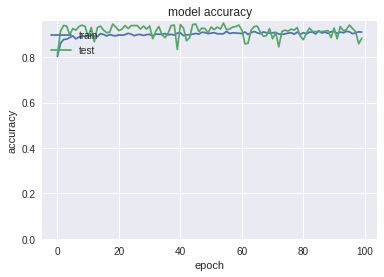

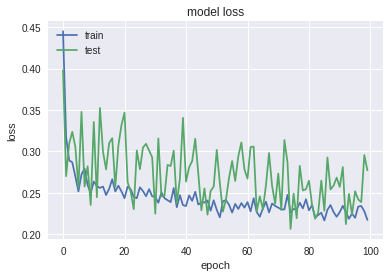

In [0]:
import matplotlib.pyplot as plt

print(history.history.keys())

# Plot curve for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(bottom=0)
plt.show()

# Plot curve for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model evaluation

## Acuracy and Loss scores
The model performed an **accuracy of 83.97%** on the testing set.

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.models import load_model

# delete model
del model

# Load best model
model = load_model(SAVED_MODEL_PATH)

loss, accuracy = model.evaluate_generator(generator=test_gen, steps=test_gen.n)

print("Loss: {}    ---    Accuracy: {}%".format(round(loss, 3), round(accuracy * 100, 2)))

Loss: 0.355    ---    Accuracy: 83.97%


In [0]:
!ls -l --block-size=M

## Confusion Matrix
The confusion matrice shows the model detected 303 True Positives (correctly classified as Pneumonia), 203 True Negatives (correctly classified as Normal) but also a high rate of False Positives (87) and False Negatives (31).  The high number of False Positives can be explained by the fact that we applied class weighting during training. We actually penalise the network 3 times more when normal chest is predicted as pneumonia. We procedeed in that way because during our firsts trainings, almost two third of the test set is predicted as Pneumonia which is due to the presence of a number of images of pneumonia 3 times higher, arguably.

Number of predicted normal cases: 290


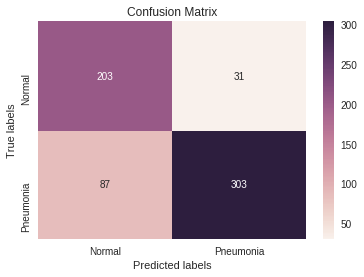

In [0]:
# Install seaborn, for a fancy (heated) confusion matrix
!pip install seaborn
import seaborn as sns

Y_pred = model.predict_generator(generator=test_gen, steps=test_gen.n)

y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes # Array of true labels

pred_normal = [i for i in y_pred if i == 0]
print("Number of predicted normal cases:", len(pred_normal))

cm = confusion_matrix(y_true, y_pred)  

# Plot confusion matrix

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Pneumonia', 'Normal']);

## Precision, Recall and F1score 
Le classi

In [0]:
print('Classification Report')
target_names = ['NORMAL', 'PNEUNOMIA']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.70      0.87      0.77       234
   PNEUNOMIA       0.91      0.78      0.84       390

   micro avg       0.81      0.81      0.81       624
   macro avg       0.80      0.82      0.81       624
weighted avg       0.83      0.81      0.81       624



## ROC curve

The area under the curve is 88% which is the worse among the 3 classifiers we trained for this lab. Our ROC curve shows also we can reach  ~85% of true positive rate along with ~17% of false positives rate on the test.  If we tolerate missing a maximum of 10% of false positives, the model could perform only about 70% of true positive rate on the test.

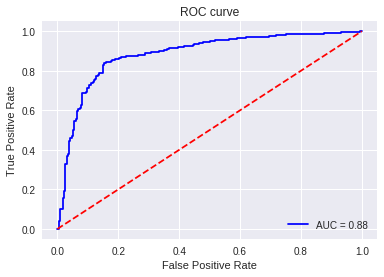

In [0]:
# Predicted probability scores for pneumnia (positives)
pneumnia_scores = Y_pred[:, 1]

# y_true defined in "Confusion Matrix" section represent
# the labels (observed value)
fpr, tpr, thresholds = roc_curve(y_true, pneumnia_scores)
roc_auc = auc(fpr, tpr)

# PLot the roc curve
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Exemples of good and bad predictions

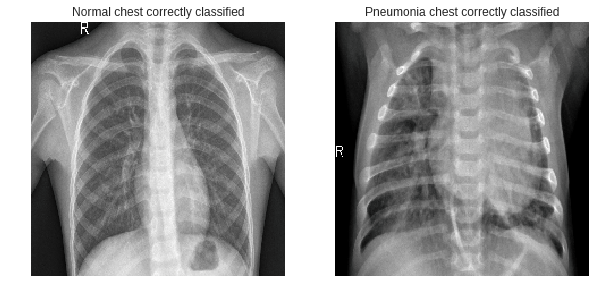

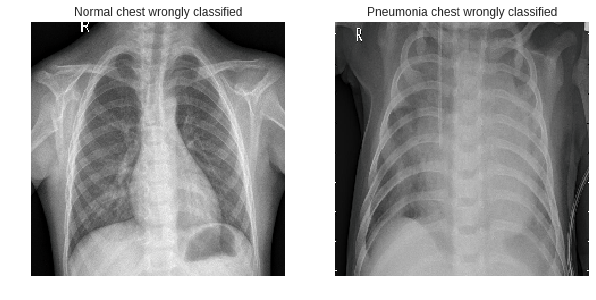

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [0]:
""" Get image at index specified from the test set """
def getTestImageFromIndex(index):
  return test_gen.__getitem__(index)[0]

def show_images_side_by_side(img1, img2, title1, title2):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))
  ax1.imshow(img1.reshape(INPUT_WIDTH, INPUT_HEIGHT, 3))
  ax2.imshow(img2.reshape(INPUT_WIDTH, INPUT_HEIGHT, 3))
  ax1.set_title(title1)
  ax2.set_title(title2) 
  ax1.set_axis_off()
  ax2.set_axis_off()
  plt.show()

def denormalize_image(x):
  """ 
    When loading the images with ImageDataGenerator in section load dataset
    image was normalized with the function preprocess_image defined in 
    https://github.com/keras-team/keras-applications/blob/8c5f4fbc5833911ddb02e8257eff9ade22e8c0ea/keras_applications/imagenet_utils.py#L157
    
    So we denormalize the images to restore its original format before showing it with matplotlib.
  """
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  
  # Our images have channel_last data_format.
  x[..., 0] *= std[0]
  x[..., 1] *= std[1]
  x[..., 2] *= std[2]
  
  x[..., 0] += mean[0]
  x[..., 1] += mean[1]
  x[..., 2] += mean[2]
  
  return x
      
# Get one indexe of correct negative (normal chest) and correct positive (pneumonia) prediction
correct_pred_of_normal_chest = [i for i, x in enumerate(y_true) if x == 0 and x == y_pred[i]][0]
correct_pred_of_pneumonia_chest = [i for i, x in enumerate(y_true) if x == 1 and x == y_pred[i]][0]

# Get one indexe of wrong negative (normal chest) and wribg positive (pneumonia) prediction
wrong_pred_of_normal_chest = [i for i, x in enumerate(y_true) if x == 0 and x != y_pred[i]][0]

# Currently all Pneumonia are correctly classified due to data unbalance
try:
  wrong_pred_of_pneumonia_chest = [i for i, x in enumerate(y_true) if x == 1 and x != y_pred[i]][0]
  tile4 = "Pneumonia chest wrongly classified"
except:
  # No case of wrongly classified pneumonia
  # We also make sure we do not pick the index of wrong_pred_of_normal_chest
  wrong_pred_of_pneumonia_chest = [i for i, x in enumerate(y_true) if x != y_pred[i] and i != wrong_pred_of_normal_chest][0]
  tile4 = "Another normal chest wrongly classified"
  
correct_pred_normal_chest_img = denormalize_image(getTestImageFromIndex(correct_pred_of_normal_chest))
correct_pred_pneumonia_chest_img = denormalize_image(getTestImageFromIndex(correct_pred_of_pneumonia_chest))

wrong_pred_normal_chest_img = denormalize_image(getTestImageFromIndex(wrong_pred_of_normal_chest))
wrong_pred_pneumonia_chest_img = denormalize_image(getTestImageFromIndex(wrong_pred_of_pneumonia_chest))

show_images_side_by_side(correct_pred_normal_chest_img, 
                         correct_pred_pneumonia_chest_img, 
                         "Normal chest correctly classified",
                         "Pneumonia chest correctly classified")

show_images_side_by_side(wrong_pred_normal_chest_img, 
                         wrong_pred_pneumonia_chest_img, 
                         "Normal chest wrongly classified",
                         tile4)

# Show array of true labels and predicted values
print(y_true)
print('---------------------------------------------------------------------')
print(y_pred)


# Save best model in my Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#!ls "/content/drive/My Drive"
TP_DL_dir = "/content/drive/My\ Drive/TP_DL"

BEST_WEIGHTS = (TP_DL_dir + "/densenet_weights.hd5").replace('\ ', ' ')
BEST_MODEL = (TP_DL_dir + "/densenet_model.hd5").replace('\ ', ' ')

print(BEST_MODEL)

model.save_weights(BEST_WEIGHTS)
model.save(BEST_MODEL)

!ls {TP_DL_dir}

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/TP_DL/densenet_model.hd5
densenet_model.hd5  densenet_weights.hd5  own_model.hd5


# References
1. https://keras.io/
2. https://scikit-learn.org/stable/documentation.html
3. https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785#answer-48018785
4. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python?rq=1#answer-38467407